# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
!rm -rf ./runs/ppo/

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [3]:
# env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe')
env = UnityEnvironment(file_name='./Reacher_Windows_x86_64_v1/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
import random
import torch
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import pdb

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/ppo')

E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda2\envs\drlnd\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:5

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
%load_ext tensorboard

In [11]:
import ppo_model
import ppo_util

from ppo_model import Policy
from ppo_util import clipped_surrogate, collect_trajectories, normalize_reward

In [12]:
policy=Policy(state_size=state_size, action_size=action_size, seed=123).to(device)
# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

In [13]:
def ppo(n_episodes=100, print_every=10, tmax=200, discount= 0.99, optimization_epochs=5, mini_batch_size=64, beta=0.5):
    scores_deque = deque(maxlen=print_every)
    # keep track of progress
    scores = []
    g_step = 0
    for i_episode in range(1, n_episodes+1):
        score    = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states   = env_info.vector_observations
        state    = states[0]
        # start all random parallel agents
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        action = torch.from_numpy(actions[0]).float().to(device)
        while True:
            old_probs, states, actions, rewards, done = collect_trajectories(env, brain_name, policy, state, action, num_agents, action_size, tmax=tmax)
            step_rewards = np.sum(rewards, axis=0)
            score += step_rewards
            if done:
                break 
            state  = states[-1]
            action = actions[-1]          
            rewards_normalized = normalize_reward(rewards, discount)
            writer.add_scalar('rewards', step_rewards, g_step)
            writer.add_scalar('action_1', action[0], g_step)
            writer.add_scalar('action_2', action[1], g_step)
            writer.add_scalar('action_3', action[2], g_step)
            writer.add_scalar('action_4', action[3], g_step)
            for _ in range(optimization_epochs):
                sampler = np.random.choice(len(rewards_normalized), mini_batch_size)
                sample_old_probs = [old_probs[sample] for sample in sampler]
                sample_states    = [states[sample] for sample in sampler ]
                sample_actions   = [actions[sample] for sample in sampler ]
                sample_rewards   = [rewards_normalized[sample] for sample in sampler]
#                 pdb.set_trace()
                L = -clipped_surrogate(policy, sample_old_probs, sample_states, sample_actions, sample_rewards, beta=beta)
                writer.add_scalar('loss', L, g_step)
                optimizer.zero_grad()
                L.backward()
                optimizer.step()
                g_step += 1
#                 del L
                # the regulation term also reduces
                # this reduces exploration in later runs
                beta*=.995
                writer.add_scalar('beta', beta, g_step)
        # get the average reward of the parallel environments           
        scores.append(np.mean(score))
        scores_deque.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(policy.state_dict(), 'checkpoint_ppo.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    return scores

In [16]:
scores = ppo(n_episodes=2000)

Episode 10	Average Score: 0.76
Episode 20	Average Score: 0.86
Episode 30	Average Score: 0.96
Episode 40	Average Score: 0.89
Episode 50	Average Score: 1.12
Episode 60	Average Score: 0.93
Episode 70	Average Score: 0.91
Episode 80	Average Score: 0.88
Episode 90	Average Score: 0.61
Episode 100	Average Score: 0.88
Episode 110	Average Score: 0.72
Episode 120	Average Score: 0.84
Episode 130	Average Score: 0.96
Episode 140	Average Score: 0.67
Episode 150	Average Score: 0.65
Episode 160	Average Score: 0.92
Episode 170	Average Score: 1.03
Episode 180	Average Score: 0.83
Episode 190	Average Score: 0.73
Episode 200	Average Score: 0.79
Episode 210	Average Score: 0.80
Episode 220	Average Score: 0.89
Episode 230	Average Score: 0.60
Episode 240	Average Score: 0.67
Episode 250	Average Score: 0.97
Episode 260	Average Score: 0.80
Episode 270	Average Score: 0.91
Episode 280	Average Score: 0.76
Episode 290	Average Score: 0.50
Episode 300	Average Score: 0.67
Episode 310	Average Score: 0.70
Episode 320	Avera

ERROR:root:Exception calling application: invalid load key, '\x7f'.
Traceback (most recent call last):
  File "E:\Anaconda2\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "E:\Anaconda2\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "E:\Anaconda2\envs\drlnd\lib\multiprocessing\connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: invalid load key, '\x7f'.
ERROR:root:Exception calling application: 
Traceback (most recent call last):
  File "E:\Anaconda2\envs\drlnd\lib\site-packages\grpc\_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "E:\Anaconda2\envs\drlnd\lib\site-packages\unityagents\rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "E:\Anaconda2\envs\drlnd\lib\multiprocessing\connection.py", line

KeyError: 'ReacherBrain'

In [15]:
%tensorboard --logdir runs/ppo --port=6060

Reusing TensorBoard on port 6060 (pid 12124), started 12:46:40 ago. (Use '!kill 12124' to kill it.)

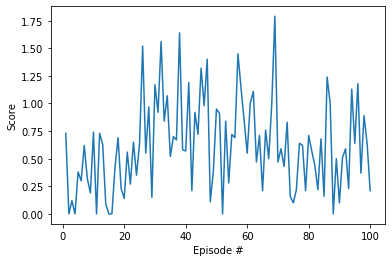

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [24]:
env.close()